![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [2]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import joblib

In [3]:
# QuantBook Analysis Tool
# For more information see [https://www.quantconnect.com/docs/v2/our-platform/research/getting-started]
qb = QuantBook()

qb.set_time_zone(TimeZones.UTC)
start_time = datetime(2015, 5, 17)
end_time = datetime(2025, 5, 17)

btc = qb.add_crypto("BTCUSD", Resolution.DAILY)

df = qb.history(TradeBar, btc.Symbol, start_time, end_time)

In [4]:
df.head()

close    high     low    open       volume
symbol time                                                   
BTCUSD 2015-05-18  237.12  238.45  236.70  236.72  4917.894131
       2015-05-19  234.04  237.89  231.66  237.10  7092.733767
       2015-05-20  232.59  234.92  231.53  234.04  6911.263524
       2015-05-21  234.54  235.00  232.54  232.58  7042.685380
       2015-05-22  235.77  236.74  234.16  234.55  6237.933652

In [5]:
df.tail()

close       high        low       open        volume
symbol time                                                                
BTCUSD 2025-05-13  102800.21  105787.37  100703.71  104137.58  10675.667581
       2025-05-14  104131.06  105038.53  101447.78  102800.22   8592.112275
       2025-05-15  103540.91  104373.00  102603.27  104131.20   7437.564062
       2025-05-16  103786.43  104200.00  101400.01  103540.91   7330.757275
       2025-05-17  103500.03  104616.71  103125.51  103786.40   6841.622878

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3653 entries, (<QuantConnect.Symbol object at 0x7b6939503580>, Timestamp('2015-05-18 00:00:00')) to (<QuantConnect.Symbol object at 0x7b6939503580>, Timestamp('2025-05-17 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   3653 non-null   float64
 1   high    3653 non-null   float64
 2   low     3653 non-null   float64
 3   open    3653 non-null   float64
 4   volume  3653 non-null   float64
dtypes: float64(5)
memory usage: 311.2+ KB


,close,high,low,open,volume
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,23574.329286,24100.678278,22955.106655,23545.215407,13988.107669
std,25778.460116,26297.804872,25177.019749,25746.727029,11594.141925
min,211.160000,225.610000,0.060000,211.160000,0.000000
25%,3867.000000,3969.370000,3770.070000,3860.000000,6455.158077
50%,10783.750000,11081.370000,10427.750000,10779.630000,10861.566757
75%,38171.570000,39472.170000,37051.360000,38118.430000,17751.067713
max,106159.260000,109358.010000,105337.970000,106164.300000,163296.940207


In [7]:
close = df.loc[:,"close"].copy()
close

symbol  time      
BTCUSD  2015-05-18       237.12
        2015-05-19       234.04
        2015-05-20       232.59
        2015-05-21       234.54
        2015-05-22       235.77
                        ...    
        2025-05-13    102800.21
        2025-05-14    104131.06
        2025-05-15    103540.91
        2025-05-16    103786.43
        2025-05-17    103500.03
Name: close, Length: 3653, dtype: float64

<Axes: xlabel='symbol,time'>

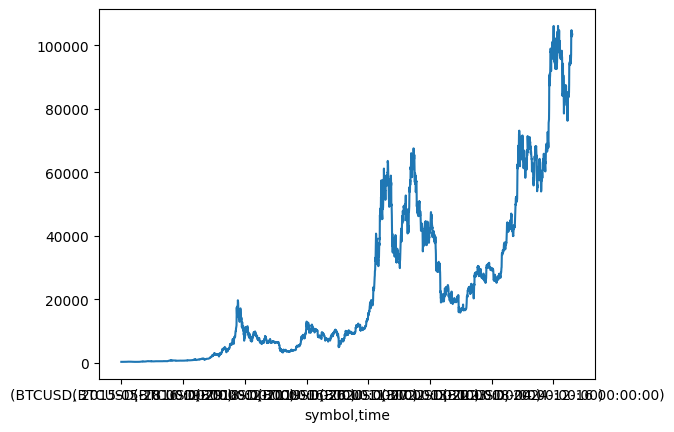

In [8]:
close.plot()

In [9]:
df["return_pct"] = close.sub(close.shift(periods=1)).div(close.shift(periods=1))
df.dropna(inplace=True)
df[:6]

close    high     low    open       volume  return_pct
symbol time                                                               
BTCUSD 2015-05-19  234.04  237.89  231.66  237.10  7092.733767   -0.012989
       2015-05-20  232.59  234.92  231.53  234.04  6911.263524   -0.006196
       2015-05-21  234.54  235.00  232.54  232.58  7042.685380    0.008384
       2015-05-22  235.77  236.74  234.16  234.55  6237.933652    0.005244
       2015-05-23  240.45  242.00  235.11  235.77  7693.310352    0.019850
       2015-05-24  239.36  240.64  237.89  240.41  3726.990145   -0.004533

In [10]:
n_steps = 5
features = []
labels = []
for i in range(len(df)-n_steps):
    features.append(df["return_pct"].iloc[i:i+n_steps].values)
    labels.append(df["return_pct"].iloc[i+n_steps])
print(features[:3])
print(labels[:3])

[array([-0.0129892 , -0.00619552,  0.00838385,  0.00524431,  0.01984985]), array([-0.00619552,  0.00838385,  0.00524431,  0.01984985, -0.00453317]), array([ 0.00838385,  0.00524431,  0.01984985, -0.00453317,  0.0060996 ])]
[-0.004533166978581722, 0.006099598930481198, -0.01407690391163519]


In [11]:
features = np.array(features)
labels = np.array(labels)

In [12]:
features_mean = features.mean()
features_std = features.std()

labels_mean = labels.mean()
labels_std = labels.std()

X = (features - features_mean) / features_std
y = (labels - labels_mean) / labels_std

In [13]:
print(features_mean)
print(features_std)

0.0023283005951960775
0.036133938445466036


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [16]:
params = {
    "booster": "gbtree",
    "colsample_bynode": 0.8,
    "learning_rate": 0.1,
    #"lamba": 0.1, 
    "max_depth": 5, 
    "num_parallel_tree": 100,
    "objective": "reg:squarederror",
    "subsample": 0.8,
}
model = xgb.train(params, dtrain, num_boost_round = 10)

In [17]:
dtest = xgb.DMatrix(X_test, label = y_test)

In [18]:
y_predict = model.predict(dtest)

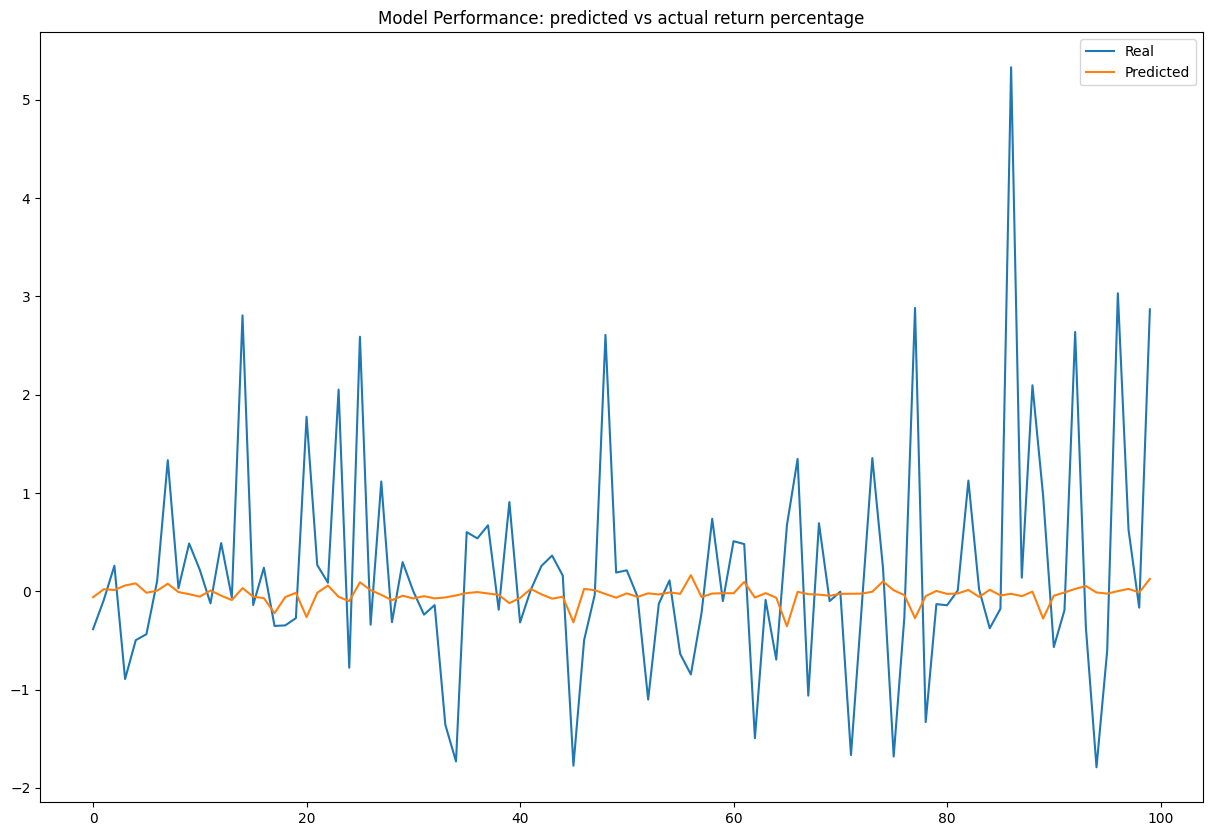

In [19]:
df = pd.DataFrame({'Real': y_test[:100].flatten(), 'Predicted': y_predict[:100].flatten()})
df.plot(title='Model Performance: predicted vs actual return percentage', figsize=(15, 10))
plt.show()

In [20]:
model_key = "model"

In [21]:
file_name = qb.object_store.get_file_path(model_key)

In [22]:
joblib.dump(model, file_name)

['/Storage/model']